In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
from tqdm import tqdm

In [2]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nehal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nehal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Initialize tools for preprocessing
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

In [4]:
# Load dataset
data = pd.read_csv(r"C:\Users\nehal\Documents\GitHub\msba265-finalstorage\data_storage\Text\twitter.csv", encoding='latin1')

In [5]:
data.isnull().sum()

No.        1000
Message    1000
Source     1000
Label      1000
Emotion    1000
dtype: int64

In [6]:
# Display the first few rows
data.head()

,No.,Message,Source,Label,Emotion
0,1.0,i feel awful about it too because it s my job ...,Twitter,0.0,sadness
1,2.0,im alone i feel awful,Twitter,0.0,sadness
2,3.0,ive probably mentioned this before but i reall...,Twitter,1.0,joy
3,4.0,i was feeling a little low few days back,Twitter,0.0,sadness
4,5.0,i beleive that i am much more sensitive to oth...,Twitter,2.0,love


In [7]:
data.drop('No.',axis=1, inplace=True)

In [8]:
data.head()

,Message,Source,Label,Emotion
0,i feel awful about it too because it s my job ...,Twitter,0.0,sadness
1,im alone i feel awful,Twitter,0.0,sadness
2,ive probably mentioned this before but i reall...,Twitter,1.0,joy
3,i was feeling a little low few days back,Twitter,0.0,sadness
4,i beleive that i am much more sensitive to oth...,Twitter,2.0,love


In [9]:
# Data Cleaning
data_cleaned = data.copy()
data_cleaned['Label'] = data_cleaned['Label'].fillna(5)
data_cleaned['Message'] = data_cleaned['Message'].fillna('no message')
data_cleaned['Source'] = data_cleaned['Source'].fillna('Twitter')
data_cleaned['Emotion'] = data_cleaned['Emotion'].fillna('suprise')
data_cleaned.columns = data_cleaned.columns.str.strip().str.lower().str.replace(" ", "_")  # Standardize column names

In [10]:
data_cleaned
print(data_cleaned.isnull().sum())

message    0
source     0
label      0
emotion    0
dtype: int64


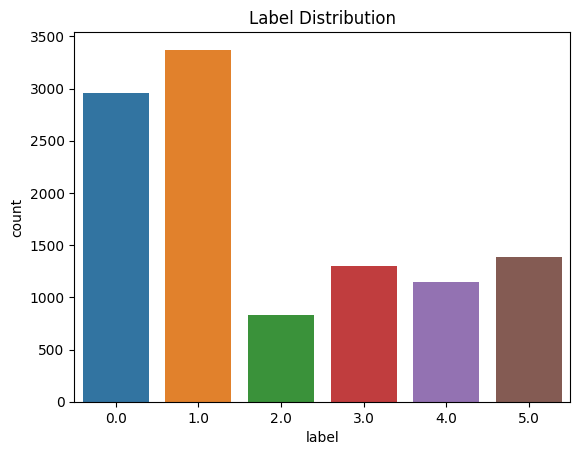

In [11]:
# EDA: Distribution of Labels
sns.countplot(data=data_cleaned, x='label')
plt.title("Label Distribution")
plt.show()

In [12]:
data_cleaned['message'].isnull().sum()

0

In [13]:
# Add message length as a feature
data_cleaned['message_length'] = data_cleaned['message'].apply(len)

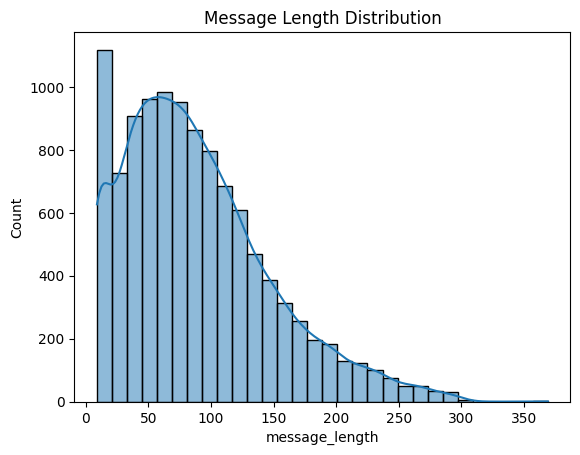

In [14]:
# Plot message length distribution
sns.histplot(data=data_cleaned, x='message_length', bins=30, kde=True)
plt.title("Message Length Distribution")
plt.show()

In [15]:
# Encode the target column
encoder = LabelEncoder()
data_cleaned['label_encoded'] = encoder.fit_transform(data_cleaned['label'])

In [16]:
data_cleaned['label_encoded']

0        0
1        0
2        1
3        0
4        2
        ..
10995    5
10996    5
10997    5
10998    5
10999    5
Name: label_encoded, Length: 11000, dtype: int64

In [17]:
np.isnan(data_cleaned['label_encoded']).sum()

0

In [18]:
# Prepare the target variable
y = data_cleaned['label_encoded']

In [19]:
# Feature Engineering
data_cleaned['num_exclamation'] = data_cleaned['message'].str.count('!')
data_cleaned['num_mentions'] = data_cleaned['message'].str.count('@')
data_cleaned['num_hashtags'] = data_cleaned['message'].str.count('#')
additional_features = data_cleaned[['message_length', 'num_exclamation', 'num_mentions', 'num_hashtags']].values

In [20]:
additional_features

array([[112,   0,   0,   0],
       [ 21,   0,   0,   0],
       [152,   0,   0,   0],
       ...,
       [ 10,   0,   0,   0],
       [ 10,   0,   0,   0],
       [ 10,   0,   0,   0]], dtype=int64)

In [21]:
# Initialize stemmer and stop words
stemmer = PorterStemmer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Ensure input is a string
    if not isinstance(text, str):
        return ""  # Return an empty string for non-string values

    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove non-alphabetic tokens and stopwords
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Lemmatization (using original tokens, not stemmed)
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]

    # Return lemmatized tokens as a string
    return " ".join(lemmatized_tokens)

In [22]:
# Apply preprocessing
data['Processed'] = data['Message'].apply(preprocess_text)

In [23]:
# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=2000)
X_vectorized = vectorizer.fit_transform(data['Processed']).toarray()

In [24]:
# Convert all entries in 'Message' to strings before applying the function
data['Message'] = data['Message'].astype(str)

# Apply feature extraction
data['num_exclamation'] = data['Message'].apply(lambda x: x.count('!'))
data['num_mentions'] = data['Message'].apply(lambda x: x.count('@'))
data['num_hashtags'] = data['Message'].apply(lambda x: x.count('#'))

In [25]:
X_vectorized.shape, additional_features.shape

((11000, 2000), (11000, 4))

In [26]:
# Combine TF-IDF features with additional features
X_combined = np.hstack([X_vectorized, additional_features])
y = data_cleaned['label_encoded']

In [27]:
np.isnan(y).sum()

0

In [33]:
# Check original class distribution
print("Original class distribution:", Counter(y))

Original class distribution: Counter({1: 3372, 0: 2960, 5: 1390, 3: 1299, 4: 1146, 2: 833})


In [34]:
# Apply SMOTE with adjusted sampling strategy
smote = SMOTE(sampling_strategy={
    0: 3372,  # Upsample class 0 to 3372
    2: 3000,  # Upsample class 2 to 3000
    3: 3000,  # Upsample class 3 to 3000
    4: 3000,  # Upsample class 4 to 3000
    5: 3000   # Upsample class 5 to 3000
}, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_combined, y)

In [35]:
# Scale features after SMOTE
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

In [36]:
# Check new class distribution
print("Class distribution after SMOTE:", Counter(y_resampled))

Class distribution after SMOTE: Counter({0: 3372, 1: 3372, 2: 3000, 3: 3000, 4: 3000, 5: 3000})


In [37]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [ ]:
# Hyperparameter Tuning for Logistic Regression
from sklearn.model_selection import GridSearchCV
log_reg = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization parameter
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [ ]:
# Get the best model
best_model = grid_search.best_estimator_

In [ ]:
# Evaluate the best model on the test set
y_pred_best = best_model.predict(X_test)
print(f"Best Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_best):.2f}")
print("\nBest Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_best))

In [ ]:
# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', verbose=30, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [ ]:
# Get the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

In [ ]:
# Evaluate the best Random Forest model
y_pred_rf = best_rf_model.predict(X_test)
print(f"Best Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print("\nBest Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))